In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visualization style
plt.style.use('default')  # Use default matplotlib style
sns.set_theme()  # Apply seaborn default theme


In [16]:
# Load the dataset
print("Loading data...")
df_train = pd.read_csv('/Users/satwiksatat/Downloads/house-prices-advanced-regression-techniques/train.csv')

# Display basic information about the dataset
print("Dataset Shape:", df_train.shape)
print("\nFirst few rows of the dataset:")
display(df_train.head())

# Display basic information about the features
print("\nDataset Info:")
df_train.info()


Loading data...
Dataset Shape: (1460, 81)

First few rows of the dataset:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64 

In [17]:
# Create a copy of the dataframe for preprocessing
df = df_train.copy()

# Handle missing values
print("Handling missing values...")
# For numeric columns, fill with median
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Fix the pandas warning by using proper method
for col in numeric_columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# Display missing values after handling
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if len(missing_values) > 0:
    print("\nRemaining missing values:")
    print(missing_values)
else:
    print("\nNo missing values remain in numeric columns")


Handling missing values...

Remaining missing values:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
Electrical         1
dtype: int64


In [18]:
# Feature Engineering
print("Creating new features...")
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalBathrooms'] = df['FullBath']  # Simplified for the demo
df['HouseAge'] = df['YrSold'] - df['YearBuilt']

# Select only the features we want to use
selected_features = [
    'LotArea',
    'YearBuilt',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'BedroomAbvGr',
    'FullBath',
    'GarageArea',
    'OverallQual',
    'TotalSF',
    'TotalBathrooms',
    'HouseAge'
]

# Display summary statistics of engineered features
print("\nSummary statistics of engineered features:")
print(df[['TotalSF', 'TotalBathrooms', 'HouseAge']].describe())


Creating new features...

Summary statistics of engineered features:
            TotalSF  TotalBathrooms     HouseAge
count   1460.000000     1460.000000  1460.000000
mean    2567.048630        1.565068    36.547945
std      821.714421        0.550916    30.250152
min      334.000000        0.000000     0.000000
25%     2009.500000        1.000000     8.000000
50%     2474.000000        2.000000    35.000000
75%     3004.000000        2.000000    54.000000
max    11752.000000        3.000000   136.000000


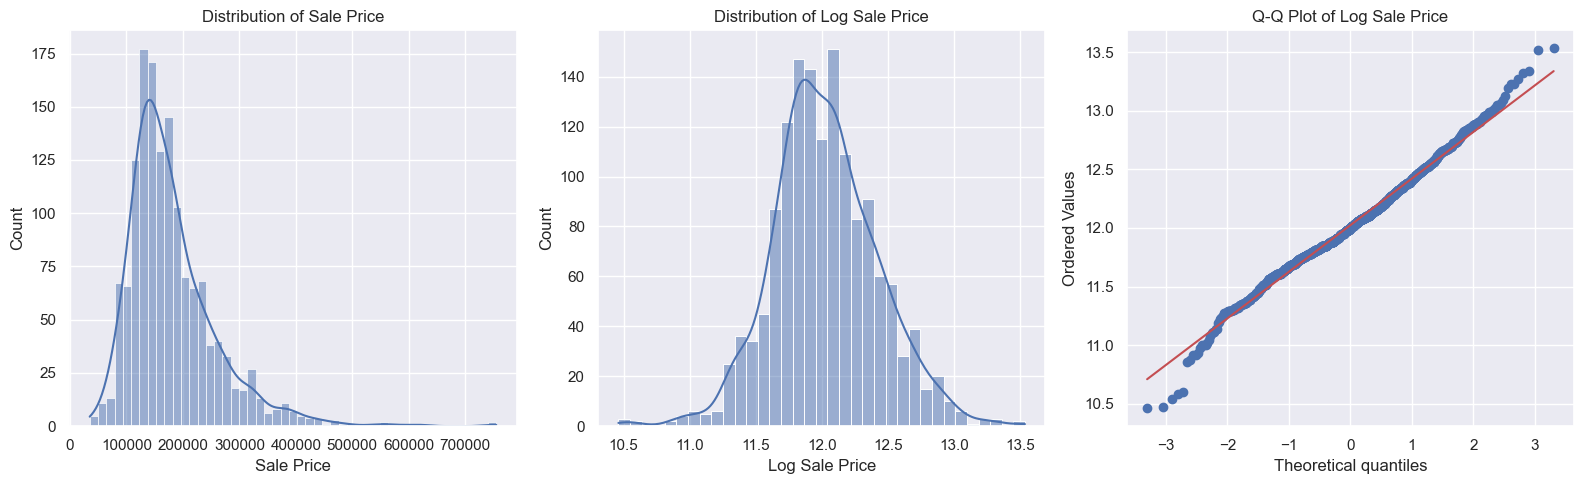


Summary Statistics of Sale Price:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Summary Statistics of Log Sale Price:
count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice_Log, dtype: float64


In [19]:
# Analyze the target variable (SalePrice)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# Distribution plot of original price
sns.histplot(data=df, x='SalePrice', kde=True, ax=ax1)
ax1.set_title('Distribution of Sale Price')
ax1.set_xlabel('Sale Price')

# Log transform the target variable
df['SalePrice_Log'] = np.log1p(df['SalePrice'])

# Distribution plot of log-transformed price
sns.histplot(data=df, x='SalePrice_Log', kde=True, ax=ax2)
ax2.set_title('Distribution of Log Sale Price')
ax2.set_xlabel('Log Sale Price')

# Q-Q plot of log-transformed price
from scipy import stats
stats.probplot(df['SalePrice_Log'], dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot of Log Sale Price')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics of Sale Price:")
print(df['SalePrice'].describe())
print("\nSummary Statistics of Log Sale Price:")
print(df['SalePrice_Log'].describe())


Splitting data into train and test sets...
Training set shape: (1168, 12)
Testing set shape: (292, 12)

Training models...

Training Linear Regression...

Training Random Forest...

Training XGBoost...

Model Results:

Linear Regression:
RMSE: 0.1712
R2: 0.8429
CV R2 Mean: 0.8030
CV R2 Std: 0.0612

Random Forest:
RMSE: 0.1654
R2: 0.8535
CV R2 Mean: 0.8409
CV R2 Std: 0.0060

XGBoost:
RMSE: 0.1769
R2: 0.8323
CV R2 Mean: 0.8271
CV R2 Std: 0.0133

Best performing model: Random Forest
CV R2 Score: 0.8409
Test R2 Score: 0.8535

Saving the best model (Random Forest)...
Model saved as 'house_price_model.joblib'


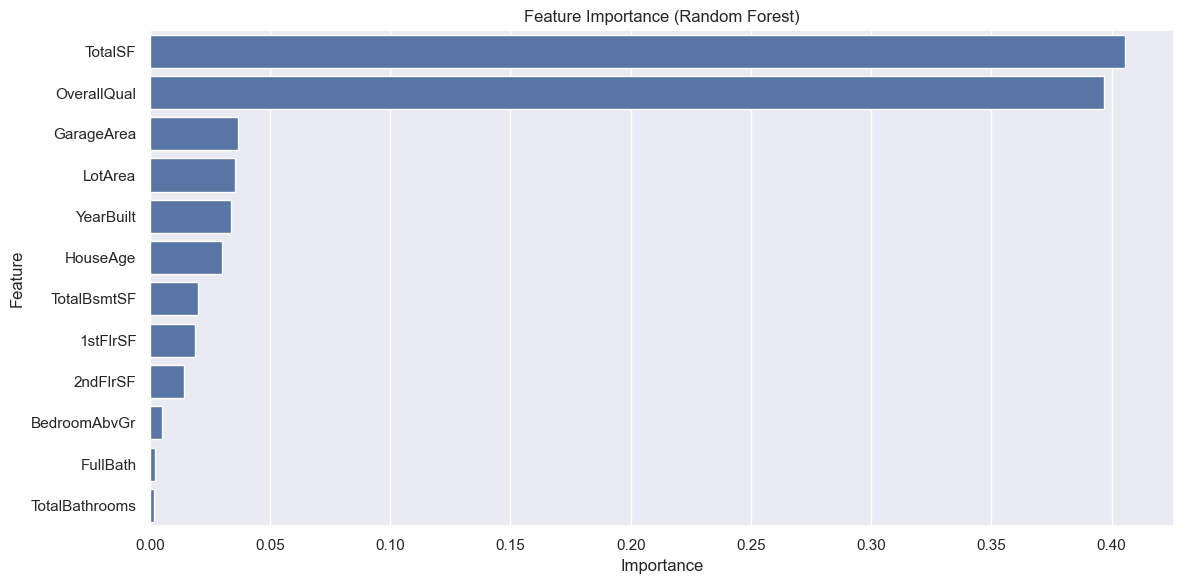

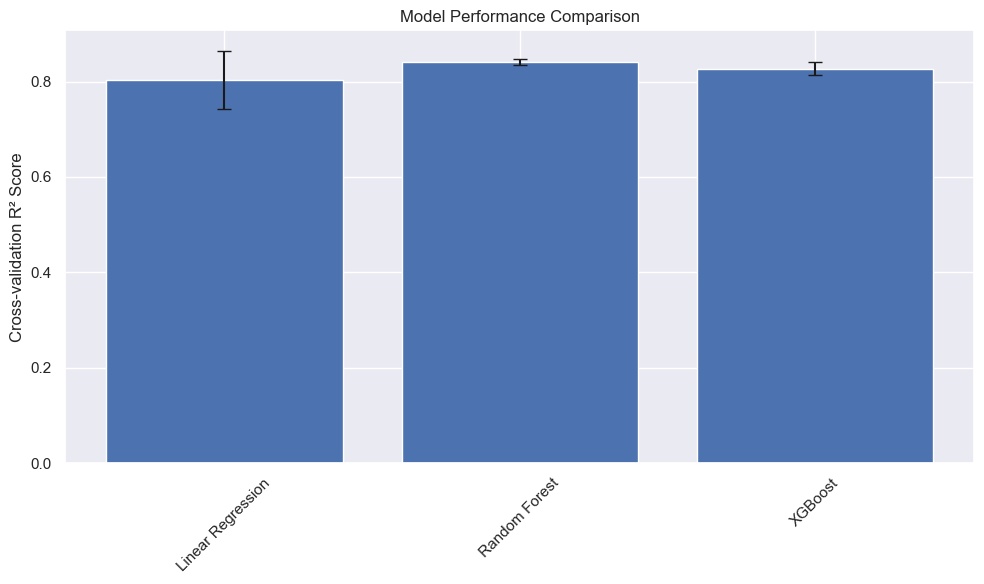

In [20]:
# Prepare features for modeling
features = df[selected_features]
target = df['SalePrice_Log']

# Split the data
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Initialize and train models
print("\nTraining models...")
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, features, target, cv=5, scoring='r2')
    
    results[name] = {
        'model': model,  # Store the model instance
        'RMSE': rmse,
        'R2': r2,
        'CV R2 Mean': cv_scores.mean(),
        'CV R2 Std': cv_scores.std()
    }

# Print results
print("\nModel Results:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric_name, value in metrics.items():
        if metric_name != 'model':  # Skip printing the model instance
            print(f"{metric_name}: {value:.4f}")

# Find the best model based on CV R2 score
best_model_name = max(results.items(), key=lambda x: x[1]['CV R2 Mean'])[0]
best_model = results[best_model_name]['model']

print(f"\nBest performing model: {best_model_name}")
print(f"CV R2 Score: {results[best_model_name]['CV R2 Mean']:.4f}")
print(f"Test R2 Score: {results[best_model_name]['R2']:.4f}")

# Save the best model
print(f"\nSaving the best model ({best_model_name})...")
joblib.dump(best_model, 'house_price_model.joblib')
print("Model saved as 'house_price_model.joblib'")

# Visualize feature importance if available
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': features.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title(f'Feature Importance ({best_model_name})')
    plt.tight_layout()
    plt.show()

# Compare model performances
plt.figure(figsize=(10, 6))
cv_scores = {name: metrics['CV R2 Mean'] for name, metrics in results.items()}
cv_errors = {name: metrics['CV R2 Std'] for name, metrics in results.items()}

plt.bar(cv_scores.keys(), cv_scores.values(), yerr=cv_errors.values(), capsize=5)
plt.title('Model Performance Comparison')
plt.ylabel('Cross-validation R² Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
